In [30]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyro
import pyro.distributions as dist
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, MaternKernel, RQKernel, PiecewisePolynomialKernel

import sys
sys.path.insert(0,"../../")
from modules.prior import UniformPrior

import tqdm

plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": "large",
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/"
dpi = 600

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# # change default font
# plt.rcParams["font.family"] = "sans-serif"
# mpl.rcParams.update({'figure.facecolor': 'white'})

Text(0.5, 1.0, 'Random variable')

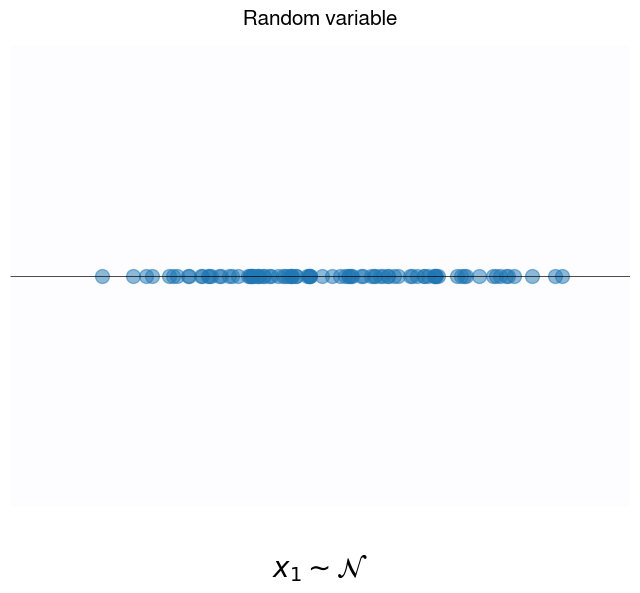

In [32]:
rng = np.random.default_rng(88)
rand_var = rng.normal(0, 1, 90)

fig, ax = plt.subplots(figsize=(8,6))
# ax.figure
ax.scatter(rand_var, np.zeros_like(rand_var), s=100, alpha=.5)
ax.hlines(0, xmin=-2.5, xmax=2.5, colors='black', lw=.5)
ax.set_xlim([-2.5, 2.5])
# # plt.ylim(-.1, .1)
# ax.set_xticks([-2, 0, 2])
# ax.set_xlabel(r'$x_1$', fontdict={'fontsize':15}, labelpad=5)
ax.set_xticks([])
ax.set_yticks([])
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# plt.axis('off')
# # Add annotation
annotation_text = r'$x_1 \sim \mathcal{N}$'
ax.annotate(annotation_text, xy=(.5, -.15), xycoords='axes fraction', fontsize=20, ha='center')

# Create line
# ax.hlines(y=0.0, xmin=0, xmax=1)
# ax.set_yticks([0,100])
# ax.set_yticks([])
ax.set_title("Random variable", fontdict={'fontsize':15}, pad=15)
# plt.title('Plot with default font')

Text(0.5, 1.0, 'Random vector')

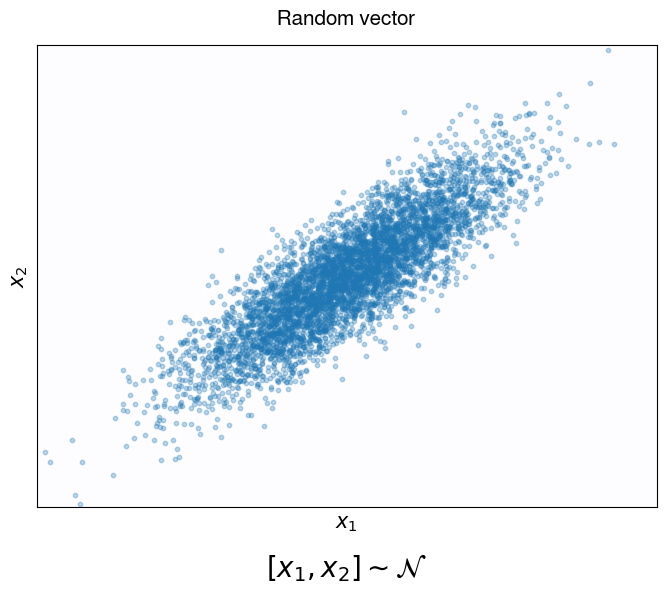

In [33]:
rng = np.random.default_rng(88)
rand_vec = rng.multivariate_normal([0,0], [[1,.85],[.85,1]], size=5000)

fig, ax = plt.subplots(figsize=(8,6))
# ax.figure
ax.scatter(rand_vec[:,0], rand_vec[:,1], s=10, alpha=.3, marker='o')
# ax.hlines(0, xmin=-2.5, xmax=2.5, colors='black', lw=.5)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
# # # plt.ylim(-.1, .1)
# ax.set_xticks([-2, 0, 2])
# ax.set_yticks([-2, 0, 2])
ax.set_xlabel(r'$x_1$', fontdict={'fontsize':15}, labelpad=5)
ax.set_ylabel(r'$x_2$', fontdict={'fontsize':15}, labelpad=5)
ax.set_yticks([])
ax.set_xticks([])
# ax.set_yticks([])
# ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# plt.axis('off')
# # Add annotation
annotation_text = r'$[x_1, x_2] \sim \mathcal{N}$'
ax.annotate(annotation_text, xy=(.5, -.15), xycoords='axes fraction', fontsize=20, ha='center')

ax.set_title("Random vector", fontdict={'fontsize':15}, pad=15)

In [34]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Set inputs
N = 1000
draws = 20
train_x = torch.empty(N)
random_func = torch.empty((N,draws))
train_x = torch.linspace(0, 1, N)

# initialise the model
kernel = ScaleKernel(RBFKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGP(train_x=train_x, train_y=random_func, likelihood=likelihood, kernel=kernel)


# Set hyperparameters
hypers = [
    {
        # 'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.33),
    }
]
model.initialize(**hypers[0])

model.eval()
torch.manual_seed(2)
with gpytorch.settings.prior_mode(True):
    for draw in range(draws):
        random_func[:,draw] = model(train_x).sample()

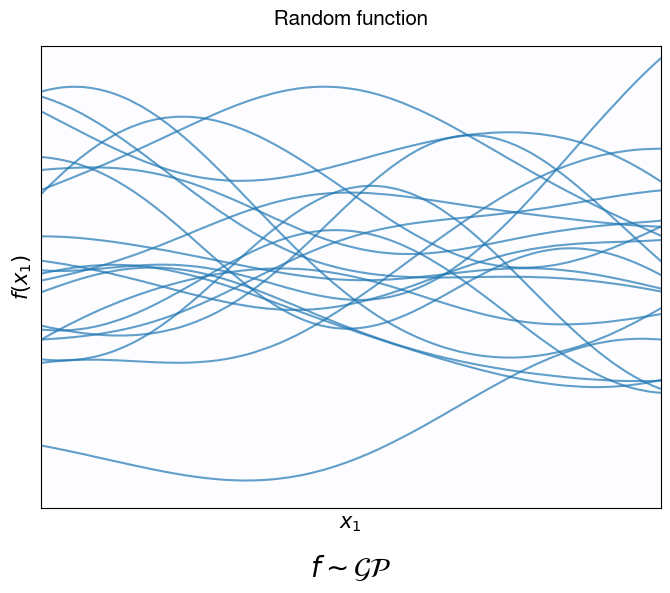

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
for draw in range(draws):
    ax.plot(train_x, random_func[:,draw], c='#1f77b4', alpha=.7)

ax.set_xlim(0,1)
ax.set_ylim(-2,2)
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([0, .5, 1.])
ax.set_xlabel(r'$x_1$', fontdict={'fontsize':15}, labelpad=5)
ax.set_ylabel(r'$f(x_1)$', fontdict={'fontsize':15}, labelpad=5)
ax.set_yticks([])
ax.set_xticks([])
annotation_text = r'$f \sim \mathcal{GP}$'
ax.annotate(annotation_text, xy=(.5, -.15), xycoords='axes fraction', fontsize=20, ha='center')
# ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# plt.axis('off')
ax.set_title("Random function", fontdict={'fontsize':15}, pad=15);

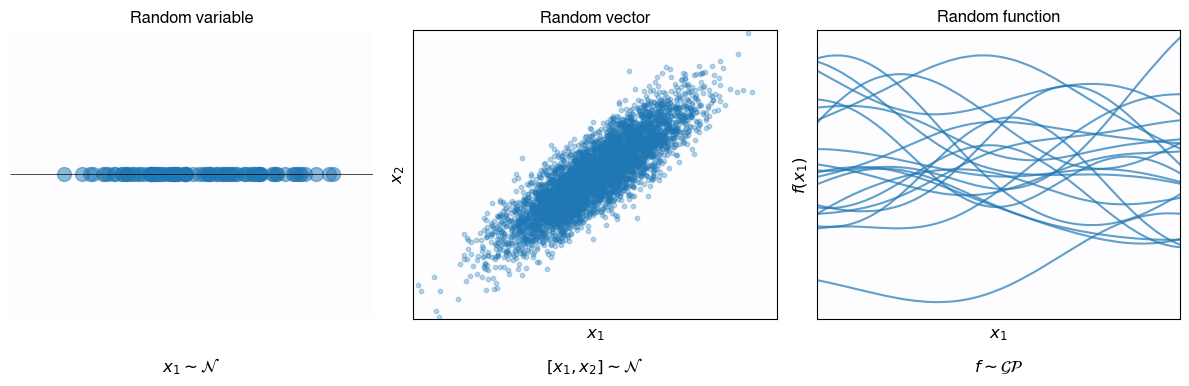

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
title_fs = 12
axis_fs = 12
annotate_fs = 12
title_pad = 5
ann_y_adjust = -.18

rng = np.random.default_rng(88)
rand_var = rng.normal(0, 1, 90)

ax[0].scatter(rand_var, np.zeros_like(rand_var), s=100, alpha=.5)
ax[0].hlines(0, xmin=-2.5, xmax=2.5, colors='black', lw=.5)
ax[0].set_xlim([-2.5, 2.5])
# # plt.ylim(-.1, .1)
# ax.set_xticks([-2, 0, 2])
# ax.set_xlabel(r'$x_1$', fontdict={'fontsize':15}, labelpad=5)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# plt.axis('off')
# # Add annotation
annotation_text = r'$x_1 \sim \mathcal{N}$'
ax[0].annotate(annotation_text, xy=(.5, ann_y_adjust), xycoords='axes fraction', fontsize=annotate_fs, ha='center')

# Create line
# ax.hlines(y=0.0, xmin=0, xmax=1)
# ax.set_yticks([0,100])
# ax.set_yticks([])
ax[0].set_title("Random variable", fontdict={'fontsize':title_fs}, pad=title_pad)
# plt.title('Plot with default font')


rng = np.random.default_rng(88)
rand_vec = rng.multivariate_normal([0,0], [[1,.85],[.85,1]], size=5000)

ax[1].scatter(rand_vec[:,0], rand_vec[:,1], s=10, alpha=.3, marker='o')
# ax.hlines(0, xmin=-2.5, xmax=2.5, colors='black', lw=.5)
ax[1].set_xlim([-4, 4])
ax[1].set_ylim([-4, 4])
# # # plt.ylim(-.1, .1)
# ax.set_xticks([-2, 0, 2])
# ax.set_yticks([-2, 0, 2])
ax[1].set_xlabel(r'$x_1$', fontdict={'fontsize':axis_fs}, labelpad=5)
ax[1].set_ylabel(r'$x_2$', fontdict={'fontsize':axis_fs}, labelpad=5)
ax[1].set_yticks([])
ax[1].set_xticks([])
# ax.set_yticks([])
# ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# plt.axis('off')
# # Add annotation
annotation_text = r'$[x_1, x_2] \sim \mathcal{N}$'
ax[1].annotate(annotation_text, xy=(.5, ann_y_adjust), xycoords='axes fraction', fontsize=annotate_fs, ha='center')
ax[1].set_title("Random vector", fontdict={'fontsize':title_fs}, pad=title_pad)


for draw in range(draws):
    ax[2].plot(train_x, random_func[:,draw], c='#1f77b4', alpha=.7)

ax[2].set_xlim(0,1)
ax[2].set_ylim(-2,2)
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([0, .5, 1.])
ax[2].set_xlabel(r'$x_1$', fontdict={'fontsize':axis_fs}, labelpad=5)
ax[2].set_ylabel(r'$f(x_1)$', fontdict={'fontsize':axis_fs}, labelpad=5)
ax[2].set_yticks([])
ax[2].set_xticks([])
annotation_text = r'$f \sim \mathcal{GP}$'
ax[2].annotate(annotation_text, xy=(.5, ann_y_adjust), xycoords='axes fraction', fontsize=annotate_fs, ha='center')
# ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# plt.axis('off')
ax[2].set_title("Random function", fontdict={'fontsize':title_fs})

fig.tight_layout()
# Reduce the spacing between the subplots

# plt.subplots_adjust(wspace=.15)

filename = "random_variable_vector_function.pdf"
if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
    os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
    print("Deleted file:", filename[:-4] + ".png")
fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0)

Short length scale

In [37]:
def plot_random_gp(kernel, hyperparam, title=None, train_x=None, train_y=None, seed=6, draws=20, colour='#1f77b4', ax=None):

    # Set inputs
    N = 1000
    draw_posterior = True
    test_y = torch.empty((N,draws))
    test_x = torch.linspace(0, 1, N)
    if (train_x is None) and (train_y is None):
        train_y = torch.empty((N,draws))
        train_x = torch.linspace(0, 1, N)
        draw_posterior = False

    # initialise the model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel)

    # init hyperparameters
    model.initialize(**hyperparam[0])

    if draw_posterior:
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()
        training_iter = 200

        # Use the adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
        
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            # print('Iter %d/%d - Loss: %.3f' % (
            #     i + 1, training_iter, loss.item(),
            # ))
            optimizer.step()
    
    
    if ax is None:        
        _, ax = plt.subplots(figsize=(8,6))
    
    model.eval()
    likelihood.eval()
    torch.manual_seed(seed)
    alpha0 = 1
    alpha1 = .15
    if draw_posterior:
        torch_settings = torch.no_grad()
    else:
        torch_settings = gpytorch.settings.prior_mode(True)
    with torch_settings, gpytorch.settings.fast_pred_var():    
        f_pred = model(test_x)
        ppd = likelihood(f_pred)            

    
    if draw_posterior:
        lower, upper = ppd.confidence_region()
        ax.plot(test_x, ppd.mean, c=colour, alpha=alpha0)
        ax.fill_between(test_x, lower, upper, alpha=alpha1)
        ylabel = r'$f ~ | ~ y$  posterior'
    else:
        for draw in range(draws):
                test_y[:,draw] = ppd.sample()
        ax.plot(test_x, test_y[:,0], c=colour, alpha=alpha0)
        ax.plot(test_x, test_y[:,1:], c=colour, alpha=alpha1)
        ylabel = r'$f$ prior'
        
    ax.set_xlim(0,1) 
    # ax.set_ylim(-10, 10)   
    ax.set_xlabel(r'$x_1$', fontdict={'fontsize':15}, labelpad=5)
    ax.set_ylabel(ylabel, fontdict={'fontsize':15}, labelpad=5)
    ax.set_yticks([])
    ax.set_xticks([])
    
    if draw_posterior:
        ax.scatter(train_x, train_y, color="k", s=40, alpha=1)
    
    ax.set_title(title, fontdict={'fontsize':15}, pad=15);

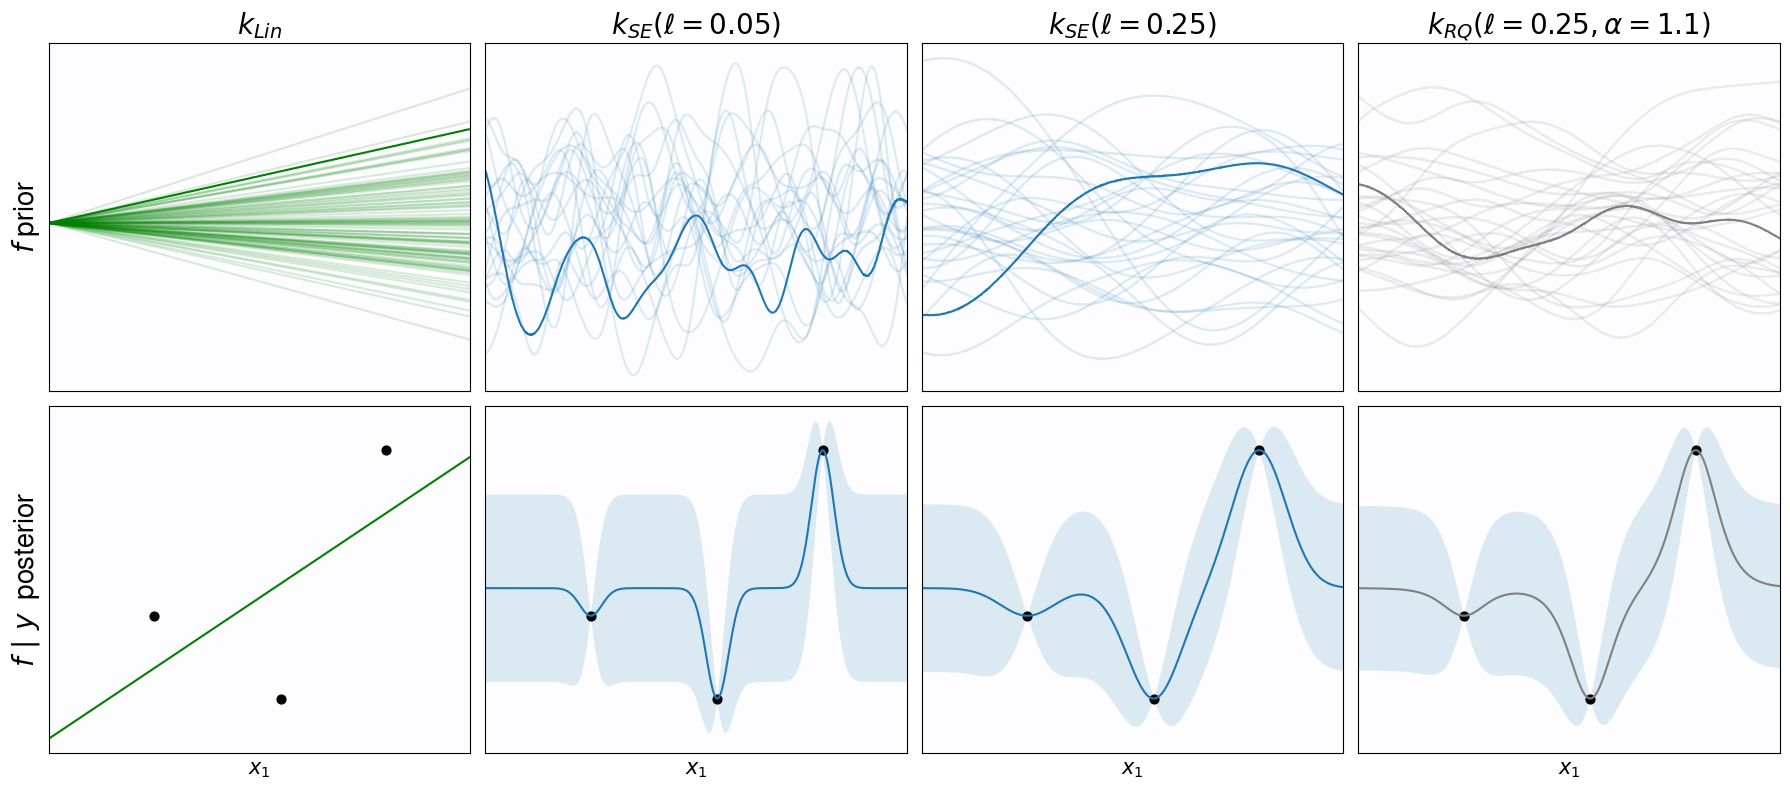

In [38]:
train_x = torch.tensor([.25, .55, .8])
train_y = torch.tensor([-1, -5, 7])

# train_x=train_x, train_y=train_y, 

# Linear kernel
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,8))
col = 0
row = 0
hyperparam_lin = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        # 'covar_module.base_kernel.lengthscale': torch.tensor(.05),
    }
]
kernel_lin = ScaleKernel(LinearKernel())
title = r"$k_{Lin}$"
plot_random_gp(kernel_lin, hyperparam=hyperparam_lin,title=title,draws=100, ax=ax[row,col], colour="green")
plot_random_gp(kernel_lin, train_x=train_x, train_y=train_y, hyperparam=hyperparam_lin,title=title,draws=100, ax=ax[row+1,col], colour="green")
ax[0,0].set_ylabel(ax[0,0].get_ylabel(), fontsize=20)
ax[1,0].set_ylabel(ax[1,0].get_ylabel(), fontsize=20)
col += 1

# SE kernel 1
hyperparam_se1 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.05),
    }
]
kernel_se1 = ScaleKernel(RBFKernel())
title = r"$k_{SE}(\ell=0.05)$"
plot_random_gp(kernel_se1, hyperparam=hyperparam_se1,title=title, ax=ax[row,col])
plot_random_gp(kernel_se1, train_x=train_x, train_y=train_y, hyperparam=hyperparam_se1,title=title, ax=ax[row+1,col])
col += 1

# SE kernel 2
hyperparam_se2 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.25),
    }
]
kernel_se2 = ScaleKernel(RBFKernel())
title = r"$k_{SE}(\ell=0.25)$"
plot_random_gp(kernel_se2, hyperparam=hyperparam_se2,title=title,draws=30, ax=ax[row,col])
plot_random_gp(kernel_se2, train_x=train_x, train_y=train_y, hyperparam=hyperparam_se2,title=title,draws=5, ax=ax[row+1,col])
col += 1

# RQ
hyperparam_rq = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.25),
        'covar_module.base_kernel.alpha': torch.tensor(1.1)
    }
]
kernel_rq = ScaleKernel(RQKernel())
title = r"$k_{RQ}(\ell=0.25, \alpha=1.1)$"
plot_random_gp(kernel_rq, hyperparam=hyperparam_rq,title=title,draws=30, seed=5, colour='grey', ax=ax[row,col])
plot_random_gp(kernel_rq, train_x=train_x, train_y=train_y, hyperparam=hyperparam_rq,title=title,draws=15, seed=5, colour='grey', ax=ax[row+1,col])
col += 1

ymin = np.repeat(np.inf, nrows)
ymax = np.repeat(-np.inf, nrows)
for i in range(nrows):
    for j in range(ncols):
        ax[0,j].set_title(ax[0,j].get_title(), fontsize=20)
        ax[0,j].set_xlabel(None)
        if i > 0:            
            ax[i,j].set_title(None)
        if j > 0:
            ax[i,j].set_ylabel(None)
            
        ymin_, ymax_ = ax[i,j].get_ylim()
        if ymin_ < ymin[i]:
            ymin[i] = ymin_
        if ymax_ > ymax[i]:
            ymax[i] = ymax_
            
for i in range(nrows):
    for j in range(ncols):        
        ax[i,j].set_ylim([ymin[i], ymax[i]])   

fig.tight_layout()

filename = "kernel_comparison1.pdf"
if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
    os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
    print("Deleted file:", filename[:-4] + ".png")
fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0)

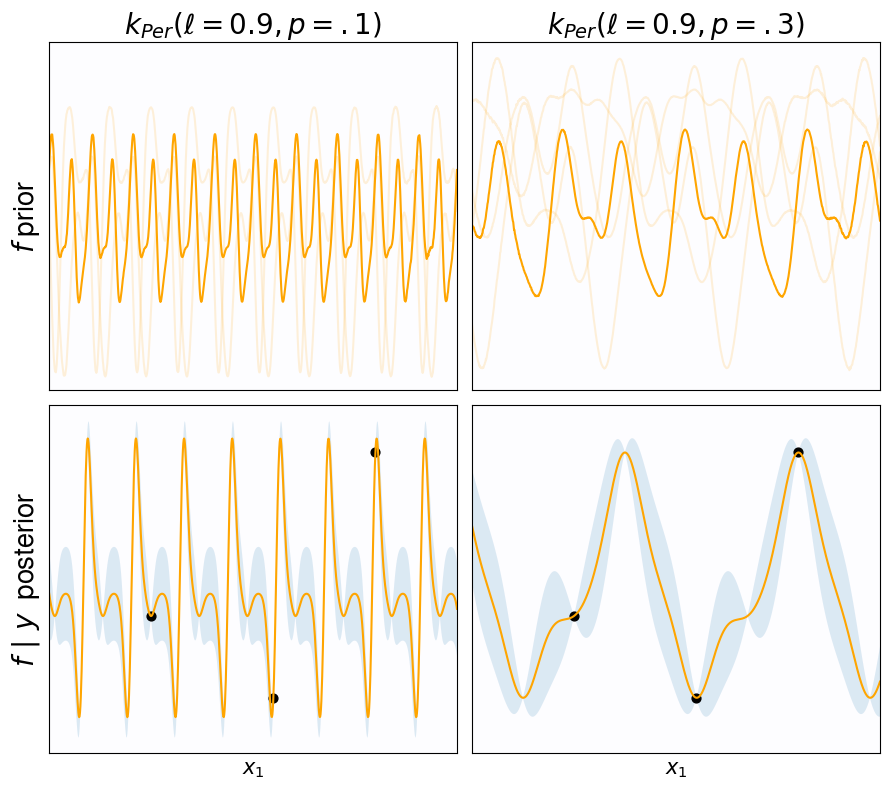

In [39]:
train_x = torch.tensor([.25, .55, .8])
train_y = torch.tensor([-1, -5, 7])

# train_x=train_x, train_y=train_y, 

# Periodic kernel 1
nrows = 2
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,8))
col = 0
row = 0

hyperparam_per1 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.9),
        'covar_module.base_kernel.period_length': torch.tensor(.1)
    }
]
kernel_per1 = ScaleKernel(PeriodicKernel())
title = r"$k_{Per}(\ell=0.9, p=.1)$"
plot_random_gp(kernel_per1, hyperparam=hyperparam_per1,title=title,draws=3, seed=5, colour='orange', ax=ax[row,col])
plot_random_gp(kernel_per1, train_x=train_x, train_y=train_y, hyperparam=hyperparam_per1,title=title,draws=3, seed=5, colour='orange', ax=ax[row+1,col])
ax[0,0].set_ylabel(ax[0,0].get_ylabel(), fontsize=20)
ax[1,0].set_ylabel(ax[1,0].get_ylabel(), fontsize=20)
col += 1

# Periodic kernel 2
hyperparam_per2 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.9),
        'covar_module.base_kernel.period_length': torch.tensor(.3)
    }
]
kernel_per2 = ScaleKernel(PeriodicKernel())
title = r"$k_{Per}(\ell=0.9, p=.3)$"
plot_random_gp(kernel_per2, hyperparam=hyperparam_per2,title=title,draws=5, seed=5, colour='orange', ax=ax[row,col])
plot_random_gp(kernel_per2, train_x=train_x, train_y=train_y, hyperparam=hyperparam_per2,title=title,draws=5, seed=5, colour='orange', ax=ax[row+1,col])
col += 1

ymin = np.repeat(np.inf, nrows)
ymax = np.repeat(-np.inf, nrows)
for i in range(nrows):
    for j in range(ncols):
        ax[0,j].set_title(ax[0,j].get_title(), fontsize=20)
        ax[0,j].set_xlabel(None)
        if i > 0:            
            ax[i,j].set_title(None)
        if j > 0:
            ax[i,j].set_ylabel(None)
            
        ymin_, ymax_ = ax[i,j].get_ylim()
        if ymin_ < ymin[i]:
            ymin[i] = ymin_
        if ymax_ > ymax[i]:
            ymax[i] = ymax_
            
for i in range(nrows):
    for j in range(ncols):        
        ax[i,j].set_ylim([ymin[i], ymax[i]])   

fig.tight_layout()

filename = "kernel_comparison2.pdf"
if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
    os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
    print("Deleted file:", filename[:-4] + ".png")
fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0)

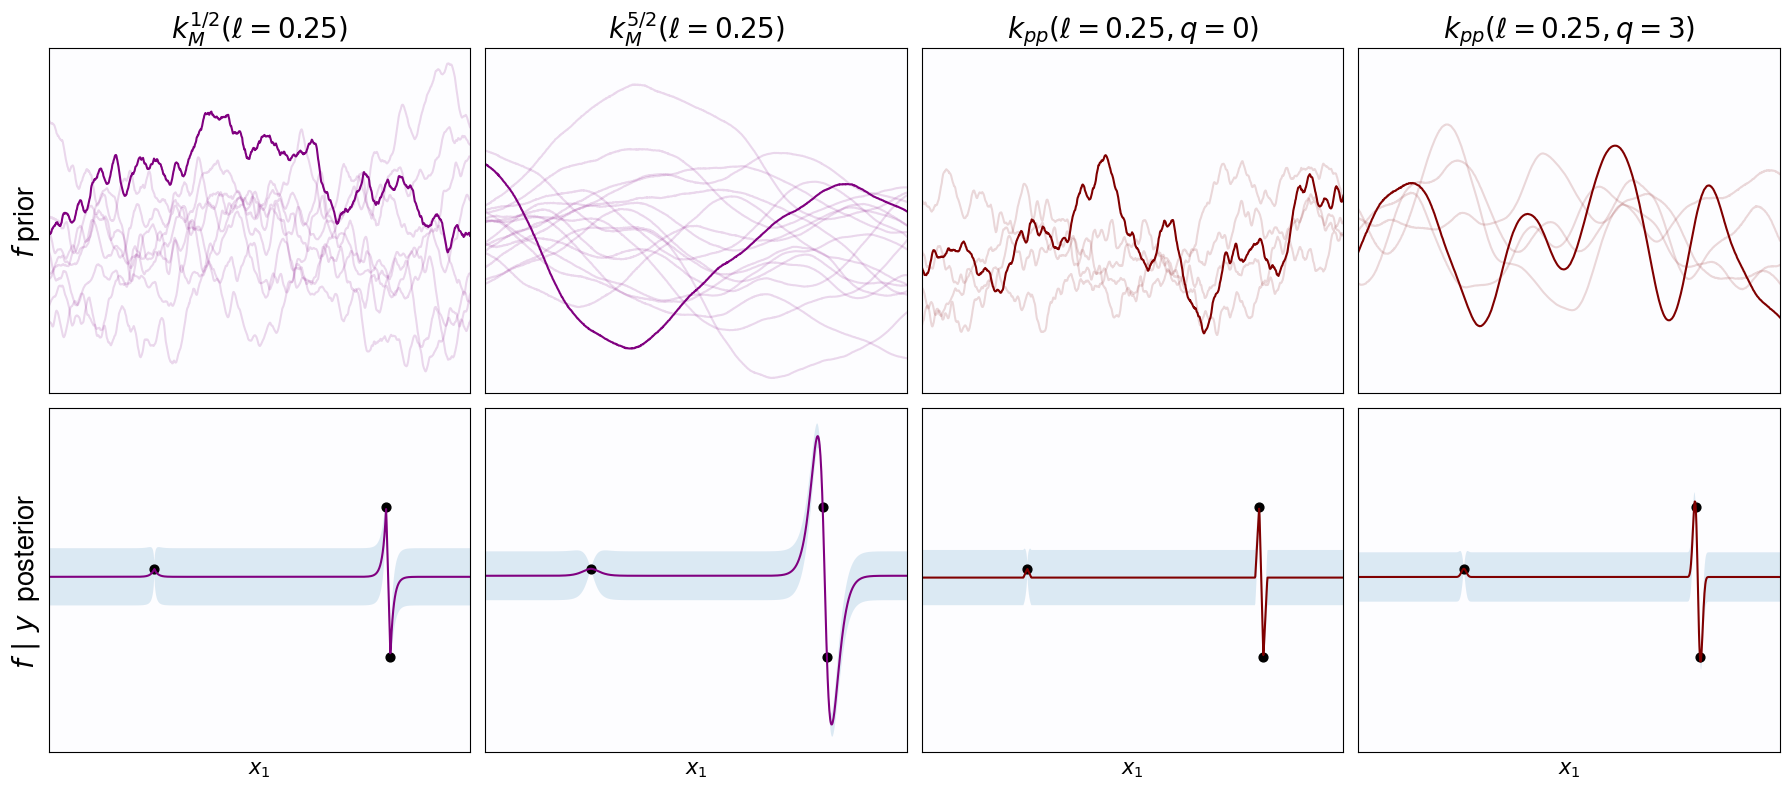

In [40]:
train_x = torch.tensor([.25, .8, .81])
train_y = torch.tensor([0, 7, -10])

# train_x=train_x, train_y=train_y, 

nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,8))
col = 0
row = 0

# Matern 1
hyperparam_m12 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.25),
    }
]
kernel_m12 = ScaleKernel(MaternKernel(nu=1/2))
title = r"$k_{M}^{1/2}(\ell=0.25)$"
plot_random_gp(kernel_m12, hyperparam=hyperparam_m12,title=title,draws=9, colour='purple', ax=ax[row,col])
plot_random_gp(kernel_m12, train_x=train_x, train_y=train_y, hyperparam=hyperparam_m12,title=title,draws=9, colour='purple', ax=ax[row+1,col])
ax[0,0].set_ylabel(ax[0,0].get_ylabel(), fontsize=20)
ax[1,0].set_ylabel(ax[1,0].get_ylabel(), fontsize=20)
col += 1

# Matern kernel 3
hyperparam_m52 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.25),
    }
]
kernel_m52 = ScaleKernel(MaternKernel(nu=5/2))
title = r"$k_{M}^{5/2}(\ell=0.25)$"
plot_random_gp(kernel_m52, hyperparam=hyperparam_m52,title=title,draws=18, seed=10, colour='purple', ax=ax[row,col])
plot_random_gp(kernel_m52, train_x=train_x, train_y=train_y, hyperparam=hyperparam_m52,title=title,draws=28, seed=10, colour='purple', ax=ax[row+1,col])
col += 1

# PP kernel 1
hyperparam_pp0 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.25),
        'covar_module.base_kernel.q': torch.tensor(0.)
    }
]
kernel_pp0 = ScaleKernel(PiecewisePolynomialKernel())
title = r"$k_{pp}(\ell=0.25, q=0)$"
plot_random_gp(kernel_pp0, hyperparam=hyperparam_pp0,title=title,draws=5, seed=5, colour='maroon', ax=ax[row,col])
plot_random_gp(kernel_pp0, train_x=train_x, train_y=train_y, hyperparam=hyperparam_pp0,title=title,draws=5, seed=5, colour='maroon', ax=ax[row+1,col])
ax[0,0].set_ylabel(ax[0,0].get_ylabel(), fontsize=20)
ax[1,0].set_ylabel(ax[1,0].get_ylabel(), fontsize=20)
col += 1

## PP kernel 4
hyperparam_pp3 = [
    {
        'likelihood.noise_covar.noise': torch.tensor(0.0001),
        'covar_module.outputscale': torch.tensor(.5),
        'covar_module.base_kernel.lengthscale': torch.tensor(.25),
        'covar_module.base_kernel.q': torch.tensor(3.)
    }
]
kernel_pp3 = ScaleKernel(PiecewisePolynomialKernel())
title = r"$k_{pp}(\ell=0.25, q=3)$"
plot_random_gp(kernel_pp3, hyperparam=hyperparam_pp3,title=title,draws=5, seed=5, colour='maroon', ax=ax[row,col])
plot_random_gp(kernel_pp3, train_x=train_x, train_y=train_y, hyperparam=hyperparam_pp3,title=title,draws=5, seed=5, colour='maroon', ax=ax[row+1,col])
col += 1

ymin = np.repeat(np.inf, nrows)
ymax = np.repeat(-np.inf, nrows)

for i in range(nrows):
    for j in range(ncols):
        ax[0,j].set_title(ax[0,j].get_title(), fontsize=20)
        ax[0,j].set_xlabel(None)
        if i > 0:            
            ax[i,j].set_title(None)
        if j > 0:
            ax[i,j].set_ylabel(None)
            
        ymin_, ymax_ = ax[i,j].get_ylim()
        if ymin_ < ymin[i]:
            ymin[i] = ymin_
        if ymax_ > ymax[i]:
            ymax[i] = ymax_
            
for i in range(nrows):
    for j in range(ncols):        
        ax[i,j].set_ylim([ymin[i], ymax[i]])               

fig.tight_layout()

filename = "kernel_comparison3.pdf"
if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
    os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
    print("Deleted file:", filename[:-4] + ".png")
fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0)